In [1]:
import numpy
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import cv2

Constants

In [2]:
RECTANGLE_WIDTH = 28.8 # mm
RECTANGLE_HEIGHT = 20.0 # mm
RECTANGLE_PERIMETER = (RECTANGLE_WIDTH + RECTANGLE_HEIGHT) * 2

#### Load the recordings
`recordings` variable is a dictionary with device MxIDs as keys and a list of recordings as values.
List of recordings is a list of tuples (image, depth) where image is a 3D numpy array of shape (height, width, 3) and depth is a 2D numpy array of shape (height, width).

In [3]:
recordings = {}

recordings_path = Path("./recordings")
for device_path in recordings_path.iterdir():
	samples = []
	for sample_path in device_path.iterdir():
		image = numpy.load(sample_path / "image.npy")
		cv2.cvtColor(image, cv2.COLOR_BGR2RGB, image)
		depth = numpy.load(sample_path / "depth.npy")
		samples.append((image, depth))

	recordings[device_path.name] = samples

#### Display the first sample

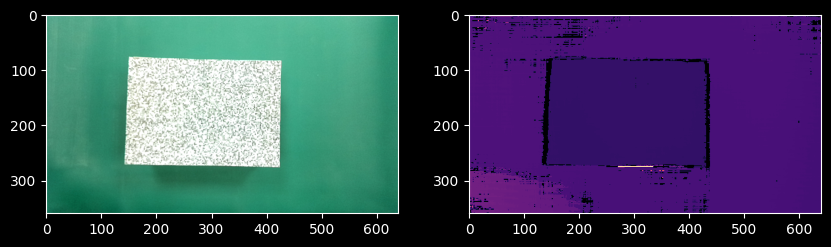

In [4]:
sample = list(recordings.values())[0][0]
image, depth = sample

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(depth, cmap="magma")

#### Crop the images

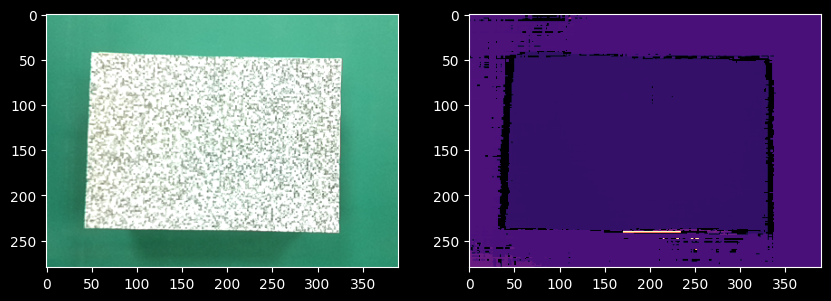

In [5]:
def crop(img):
	top_margin = 35
	bottom_margin = 45
	left_margin = 100
	right_margin = 150

	return img[top_margin:-bottom_margin, left_margin:-right_margin]
	
image_crop = crop(image)
depth_crop = crop(depth)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image_crop)
plt.subplot(1, 2, 2)
plt.imshow(depth_crop, cmap="magma")

#### Threshold the images

The color image is thresholded using the HSV color space. The depth image is thresholded using the depth value.

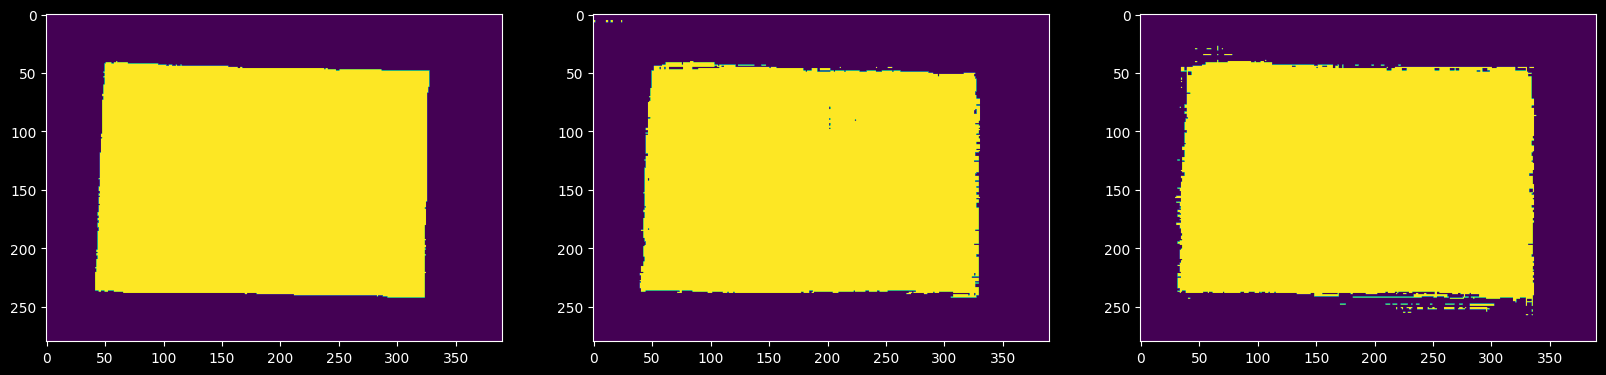

In [44]:
# rgb image thershold
def rgb_threshold(img):
	# convert to hsv
	hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
	hsv[:,:,2] = 255
	rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
	gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
	return gray > 220

# depth image threshold
def depth_threshold(img):
	return (400 < img) & (img < 600)

# alternative depth image threshold which clasifies the unknown values as the elevated plane
def depth_threshold_keep_unknown(depth_crop, image_crop):
	image_bin = rgb_threshold(image_crop)
	image_bin_30_dialated = cv2.dilate(image_bin.astype(np.uint8), np.ones((30, 30)))
	depth_masked = np.where(image_bin_30_dialated, depth_crop, 2000)

	return depth_masked < 600

image_bin = rgb_threshold(image_crop)
depth_bin_old = depth_threshold(depth_crop)
depth_bin = depth_threshold_keep_unknown(depth_crop, image_crop)

plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(image_bin)
plt.subplot(1, 3, 2)
plt.imshow(depth_bin_old)
plt.subplot(1, 3, 3)
plt.imshow(depth_bin)



#### Fit minimal rectangle

One measurement of the depth-color alignment is the alignment of the minimal rectangle on the color image and the depth image. We compute it using the `cv2.minAreaRect` function.

When we compute the minimal rectangle, we can find the ratio of the perimeter in pixels to the perimeter in meters (defined at the beginning of the script). We can use that to convert the measurements from pixels to meters.

C:\Users\njeze\AppData\Local\Temp\ipykernel_21884\3108353828.py:28: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  cv2.drawContours(image_vis, [np.int0(image_box)], 0, (0,0,255), 1)
C:\Users\njeze\AppData\Local\Temp\ipykernel_21884\3108353828.py:29: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  cv2.drawContours(depth_vis, [np.int0(depth_box)], 0, (0,0,255), 1)


rect_distance: 1.4576877355575562 px, 0.14859288968144851 mm


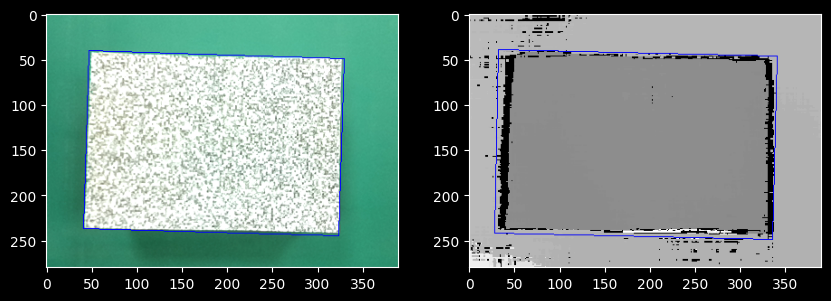

In [39]:
def fit_minimal_rectangle(img_bin):
	contours, hierarchy = cv2.findContours(img_bin.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
	c = max(contours, key=cv2.contourArea) # use the biggest contour
	# c = np.vstack(contours).squeeze() # join all contours together
	box = cv2.boxPoints(cv2.minAreaRect(c))

	return box

def get_px_to_mm(image_box):
	rectangle_perimeter_px = cv2.arcLength(image_box, True)
	return RECTANGLE_PERIMETER / rectangle_perimeter_px


def get_rect_distance(box1, box2):
	return np.linalg.norm(box1.mean(axis=0) - box2.mean(axis=0))


image_box = fit_minimal_rectangle(image_bin)
depth_box = fit_minimal_rectangle(depth_bin)

px_to_mm = get_px_to_mm(image_box)


image_vis = image_crop.copy()
depth_vis =  np.interp(depth_crop, [0, 1000], [0, 255]).astype(np.uint8)
depth_vis = np.stack([depth_vis]*3, axis=2)

cv2.drawContours(image_vis, [np.int0(image_box)], 0, (0,0,255), 1)
cv2.drawContours(depth_vis, [np.int0(depth_box)], 0, (0,0,255), 1)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image_vis)
plt.subplot(1, 2, 2)
plt.imshow(depth_vis)

rect_distance = get_rect_distance(image_box, depth_box)
rect_distance_mm = rect_distance * px_to_mm

print(f"rect_distance: {rect_distance} px, {rect_distance_mm} mm")

#### Find centroids

Another measurement of the depth-color alignment is the alignment of the centroids of the objects on the color image and the depth image. We compute it using the `cv2.moments` function.

centroid_distance: 0.8945697790461266 px, 0.09119011242782751 mm


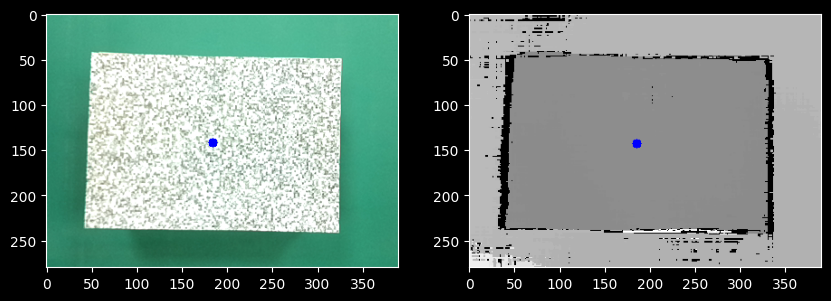

In [40]:
def get_centroid(img_bin):
	M = cv2.moments(img_bin.astype(numpy.uint8) * 255)
	return np.array([(M["m10"] / M["m00"]), (M["m01"] / M["m00"])])

image_center = get_centroid(image_bin)
depth_center = get_centroid(depth_bin)

image_vis = image_crop.copy()
depth_vis =  np.interp(depth_crop, [0, 1000], [0, 255]).astype(np.uint8)
depth_vis = np.stack([depth_vis]*3, axis=2)

cv2.circle(image_vis, (int(image_center[0]), int(image_center[1])), 5, (0,0,255), -1)
cv2.circle(depth_vis, (int(depth_center[0]), int(depth_center[1])), 5, (0,0,255), -1)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image_vis)
plt.subplot(1, 2, 2)
plt.imshow(depth_vis)


centroid_distance = np.linalg.norm(image_center - depth_center)
centroid_distance_mm = centroid_distance * px_to_mm

print(f"centroid_distance: {centroid_distance} px, {centroid_distance_mm} mm")

#### Compute border error width

The last measurement of the depth-color alignment is the border error width. First, we find pixels where the thresholded depth image and color image do not match. Usualy the mismatch is on the border of the elevated plane. We know the perimeter of the minimal rectangle (computed in the previous step) so we compute the border error width as the ratio of the number of mismatched pixels to the perimeter.

error width: 5.239958073209964 px, 0.5341476729994482 mm


True

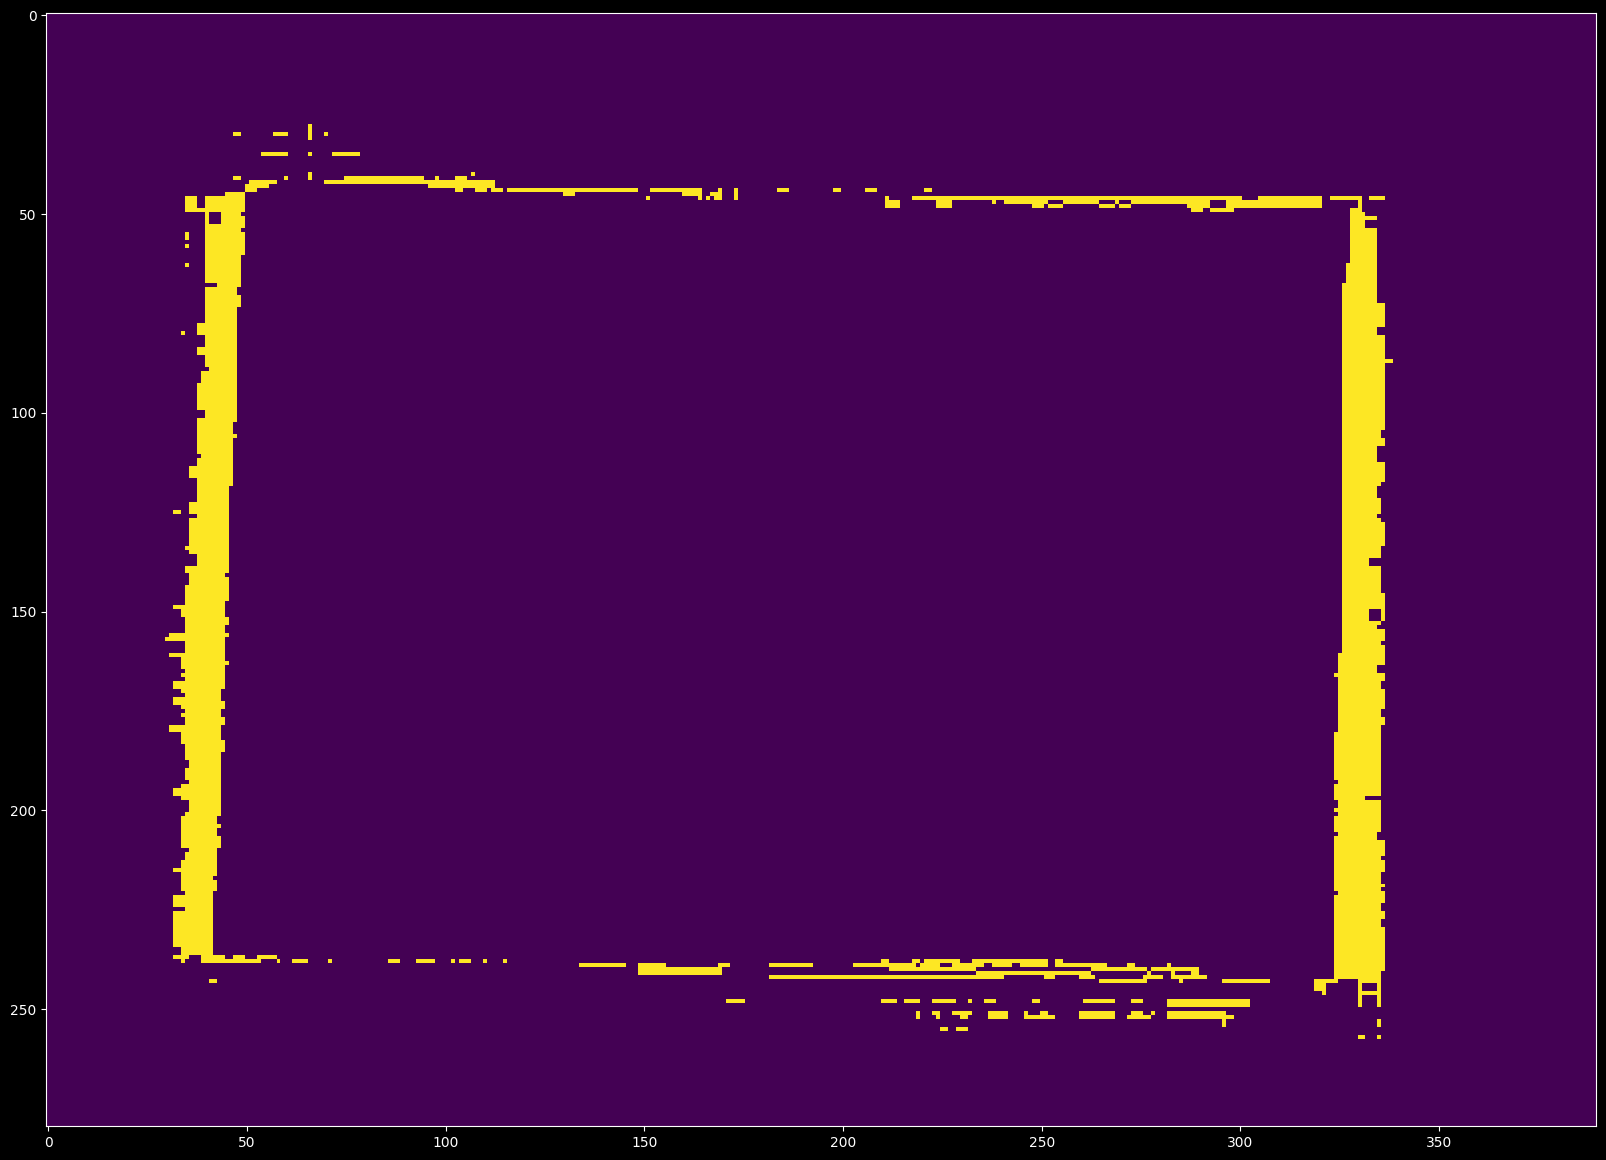

In [41]:
def get_border_error_width(image_bin, depth_bin):
	xor = (image_bin ^ depth_bin)

	error_area_px = np.count_nonzero(xor)
	avg_error_width_px = error_area_px / (RECTANGLE_PERIMETER / px_to_mm)

	return avg_error_width_px

avg_error_width_px = get_border_error_width(image_bin, depth_bin)

print(f"error width: {avg_error_width_px} px, {avg_error_width_px * px_to_mm} mm")

xor = (image_bin ^ depth_bin)
plt.figure(figsize=(20,20))
plt.imshow(xor)

cv2.imwrite("test.png", xor.astype(np.uint8)*255)

### Process all samples

For each device, we compute the average of the measurements for each sample and print the results.

In [43]:
def test_sample(sample):
	image, depth = sample

	# crop
	image_crop = crop(image)
	depth_crop = crop(depth)


	# threshold
	image_bin = rgb_threshold(image_crop)
	depth_bin = depth_threshold_keep_unknown(depth_crop, image_crop)

	# find centroid
	image_center = get_centroid(image_bin)
	depth_center = get_centroid(depth_bin)
	centroid_distance = np.linalg.norm(image_center - depth_center)
	centroid_distance_mm = centroid_distance * px_to_mm
	# print(f"centroid_distance: {centroid_distance} px, {centroid_distance_mm} mm")

	rect_distance = get_rect_distance(image_box, depth_box)
	rect_distance_mm = rect_distance * px_to_mm
	# print(f"rect_distance: {rect_distance} px, {rect_distance_mm} mm")

	# border error
	avg_error_width_px = get_border_error_width(image_bin, depth_bin)
	avg_error_width_mm = avg_error_width_px * px_to_mm
	# print(f"error width: {avg_error_width_px} px, {avg_error_width_mm} mm")


	return centroid_distance_mm, rect_distance_mm, avg_error_width_mm


print(f"device            \tcentroid_distances [mm]\trect_distances [mm]\terror_widths [mm]")
for id, device in recordings.items():
	centroid_distances = []
	rect_distances = []
	error_widths = []
	for sample in device:
		centroid, rect, widths = test_sample(sample)
		centroid_distances.append(centroid)
		rect_distances.append(rect)
		error_widths.append(widths)
	
	print(f"{id}\t{np.mean(centroid_distances)}\t{np.mean(rect_distances)}\t{np.mean(error_widths)}")


device            	centroid_distances [mm]	rect_distances [mm]	error_widths [mm]
1944301021A7751300	0.08834997227383631	0.14859288968144851	0.5249488771160213
1944301031F7731300	0.26213868669294965	0.14859288968144851	0.5742859374444934
1944301051D4751300	0.17782813941406883	0.14859288968144851	0.5837402554357932
19443010813B771300	0.1631519641584296	0.14859288968144851	0.7198803051596111
19443010A1AC731300	0.14341998066793712	0.14859288968144851	0.5110761560094181
19443010A1D3731300	0.14876016183415425	0.14859288968144851	0.4875255350671265
19443010A1EB7E1300	0.22686376139575817	0.14859288968144851	0.5123324730397936
19443010C1FB7E1300	0.32055362976332635	0.14859288968144851	0.5584648602653589
19443010D17E741300	0.2582199502371245	0.14859288968144851	0.573136087959065
19443010E1C9731300	0.2585512896244154	0.14859288968144851	0.6378151215144099
